In [1]:
import os

import keras
import tensorflow as tf

from tensorflow import config

import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import cifar10
from keras.layers import Dense, Input, Conv2D, Flatten
# from keras.callbacks import LambdaCallback, ModelCheckpoint
from numba import cuda 
# print(device)

LOAD_MODEL: bool = False
MODEL_FILENAME: str = 'cifar'
MODEL_EXT: str = 'h5'
GPU_DEVICE = cuda.get_current_device()

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

print(tf.config.list_physical_devices('GPU'))



2023-03-11 20:25:32.085886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 20:25:32.997476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/james/miniconda3/envs/tf/lib/
2023-03-11 20:25:32.999144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/james/miniconda3/envs/tf/lib/
2023-03-11 20:25:32.999159: W tensorflow/compiler/tf2ten

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-11 20:25:34.683777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 20:25:34.700127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-11 20:25:34.700389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# GET DATASETS

NUMBER_TO_LABEL_MAPPING: dict[int, str] = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

def get_numbers_data() -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    return cifar10.load_data()

(train_dataset, train_dataset_marks), (test_dataset, test_dataset_marks) = get_numbers_data()

print(f'{len(train_dataset)=}')
print(f'{len(train_dataset_marks)=}')
print(f'{len(test_dataset)=}')
print(f'{len(test_dataset_marks)=}')


len(train_dataset)=50000
len(train_dataset_marks)=50000
len(test_dataset)=10000
len(test_dataset_marks)=10000


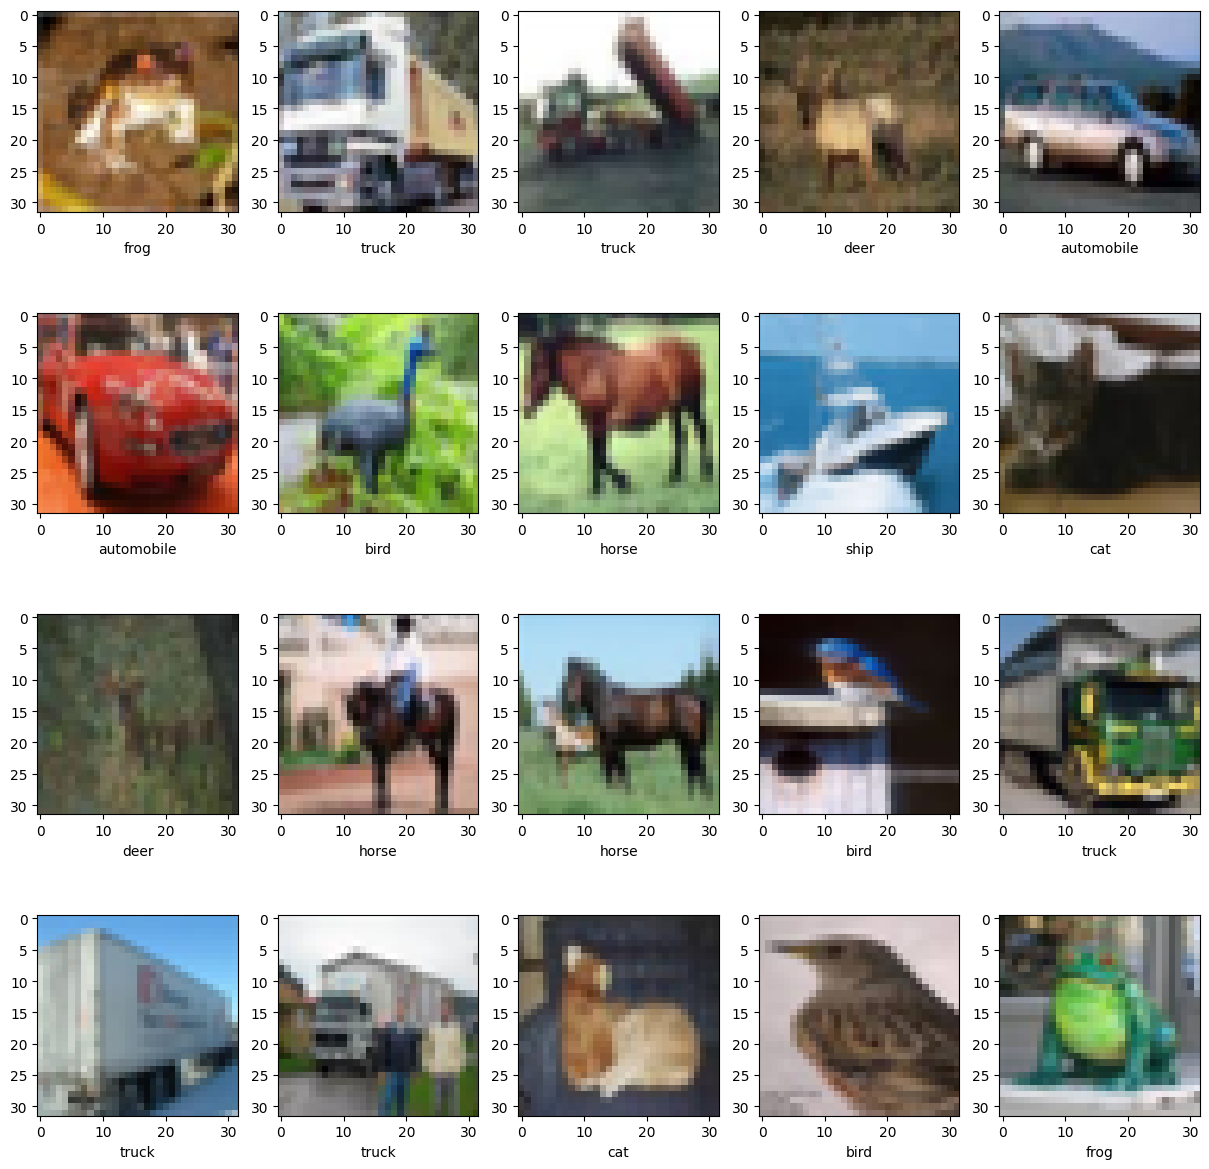

In [3]:
# SHOW EXAMPLES


def show_example_data(train_data: np.ndarray, columns: int = 4, rows: int = 5) -> None:
    figure = plt.figure(figsize=(15, 15))
    # plt.imshow(train_data[0])
    # print(train_dataset_marks[0])
    for i, img in enumerate(train_data[:columns*rows], start=1):
        figure.add_subplot(columns, rows, i)
        plt.xlabel(NUMBER_TO_LABEL_MAPPING[train_dataset_marks[i - 1][0]])
        plt.imshow(img)
        
show_example_data(train_dataset)

In [4]:
# PREPARE DATASET

from keras.utils import to_categorical

def prepare_data(raw_data: np.ndarray) -> np.ndarray:
    ret = raw_data.astype("float32") / 255

    
    # ret = ret.reshape(-1, 28*28)
    # for i, img in enumerate(raw_data):
    #     img = img.astype(np.float32) / 255.0
    #     img = img.reshape((img.shape[0]*img.shape[1], )) # (784, ) shape
    #     ret[i] = img
        
    return ret
    
    
train_prepared_dataset = prepare_data(train_dataset)
test_prepared_dataset = prepare_data(test_dataset)
train_prepared_dataset_marks = to_categorical(train_dataset_marks, 10)
test_prepared_dataset_marks = to_categorical(test_dataset_marks, 10)
input_shape: tuple[int] = train_prepared_dataset[0].shape

print(f'{len(train_prepared_dataset)=}, {len(test_prepared_dataset)=}')
print(f'img with number => {train_dataset_marks[0]} with size {train_prepared_dataset[0].size} and {train_prepared_dataset[0].shape} linear shape')
print(f'{input_shape=}')

len(train_prepared_dataset)=50000, len(test_prepared_dataset)=10000
img with number => [6] with size 3072 and (32, 32, 3) linear shape
input_shape=(32, 32, 3)


CREATING MODEL
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 16,803,114
Trainable params: 16,803,114
Non-trainable params: 0
_________________________________________________________________


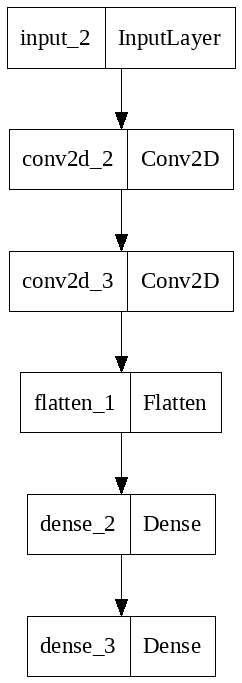

In [26]:
# MODEL

# from keras.engine.sequential import 

# Input - Входящий слой
# Dense - Полносвязный слой 
# Flatten - выравнивающий слой ()
# Rectified linear unit (ReLU) — усеченное линейное преобразование
# Softmax function — функция мягкого максимума, софтмакс

# Conv2D - Слой свёртки
# kernel - 
# filter - 
# padding: one of `"valid"` or `"same"` (case-insensitive).
# `"valid"` means no padding. `"same"` results in padding with zeros
# evenly to the left/right or up/down of the input.

if LOAD_MODEL is True:
    print(f"LOADED FROM \"{MODEL_FILENAME}\" FILE")
    model: Sequential = keras.models.load_model(MODEL_FILENAME) # type: ignore
else:
    print("CREATING MODEL")
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        Flatten(input_shape=input_shape),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax'),
    ])


model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, dpi=120)

In [27]:
import time

from keras.callbacks import LambdaCallback

EPOCHS: int = 10
BATCH_SIZE: int = 64


def check_from_test_dataset(test_index: int) -> bool:
    img_arr = test_prepared_dataset[test_index]
    value = test_prepared_dataset_marks[test_index]

    correct_ans = np.argmax(value)
    img_expanded = np.expand_dims(img_arr, axis=0)
    plt.imshow(img_arr)
    result = model.predict(img_expanded)
    predicted_number = np.argmax(result[0])

    print(f'OUTPUT => {NUMBER_TO_LABEL_MAPPING[predicted_number]} {predicted_number}')
    print(f'CORRECT ANSWER => {NUMBER_TO_LABEL_MAPPING[correct_ans]}')

    return NUMBER_TO_LABEL_MAPPING[predicted_number] == NUMBER_TO_LABEL_MAPPING[correct_ans]

result: str = ''
idx_best: int = 0
best_result: int = 0
cur_time: float = time.time()


def on_epoch_end(epoch, log):
    global cur_time, result, best_result, idx_best 
    keys = list(log.keys())
    
    output = f'Epoch №{str(epoch+1)}:\n'
    output += f'\tTrain time spended: {time.time() - cur_time:.2f}\n'
    output += f'\tAccuracy on train dataset: {log[keys[1]] * 100:.2f}%\n'

    if len(keys) > 2:
    
        output += f'\tAccuracy on test dataset: {log[keys[3]] * 100:.2f}%\n'
    
        if log[keys[3]] * 100 >= best_result:
            best_result = log[keys[3]]*100
            idx_best = epoch
            print(output)
    
    else:
        if log[keys[1]] * 100 >= best_result:
            best_result = log[keys[1]]*100
            idx_best = epoch
            print(output)
    
    cur_time = time.time()   

def on_epoch_begin(epoch, log):
    global cur_time
    cur_time = time.time()

myCB = LambdaCallback(on_epoch_end = on_epoch_end, on_epoch_begin=on_epoch_begin)

In [28]:
# TRAIN

# from numpy.random import shuffle
# shuffle(train_prepared_dataset)

from keras.callbacks import History, ModelCheckpoint

if len(train_prepared_dataset) <= 0:
    raise ValueError('train dataset is empty')

model_weights_file: str = f'{MODEL_FILENAME}_weights.{MODEL_EXT}'
model_file: str = f'{MODEL_FILENAME}.{MODEL_EXT}'

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_weights_file,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

def start_train() -> History:
    print('TRAIN WITH' + (' TEST DATASET' if len(test_prepared_dataset) > 0 else 'OUT TEST DATASET') + f' FOR {EPOCHS} EPOCHS')

    if len(test_prepared_dataset) == 0:
        return model.fit(
            train_prepared_dataset, train_prepared_dataset_marks, 
            batch_size=BATCH_SIZE, 
            epochs=EPOCHS,
            callbacks=[model_checkpoint_callback, myCB],
            verbose=''    
        )
    
    return model.fit(
        train_prepared_dataset, train_prepared_dataset_marks,
        validation_data=(train_prepared_dataset, train_prepared_dataset_marks),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        callbacks=[model_checkpoint_callback, myCB],            
        verbose='',  
    )

if tf.config.list_physical_devices('GPU'):
    print('USING GPU TO TRAIN')
    with tf.device('/device:GPU:0'): # type: ignore
        history = start_train()
else:
    print('USING CPU TO TRAIN')
    history = start_train()

model.load_weights(model_weights_file)
model.save(model_file)


USING GPU TO TRAIN
TRAIN WITH TEST DATASET FOR 10 EPOCHS


2023-03-11 20:37:09.704833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch №1:
	Train time spended: 19.04
	Accuracy on train dataset: 48.55%
	Accuracy on test dataset: 61.83%

Epoch №2:
	Train time spended: 16.50
	Accuracy on train dataset: 63.64%
	Accuracy on test dataset: 73.58%

Epoch №3:
	Train time spended: 16.82
	Accuracy on train dataset: 73.87%
	Accuracy on test dataset: 85.01%

Epoch №4:
	Train time spended: 16.63
	Accuracy on train dataset: 84.59%
	Accuracy on test dataset: 94.16%

Epoch №5:
	Train time spended: 16.53
	Accuracy on train dataset: 93.62%
	Accuracy on test dataset: 98.33%

Epoch №6:
	Train time spended: 16.46
	Accuracy on train dataset: 97.14%
	Accuracy on test dataset: 98.37%

Epoch №7:
	Train time spended: 16.33
	Accuracy on train dataset: 98.02%
	Accuracy on test dataset: 98.89%



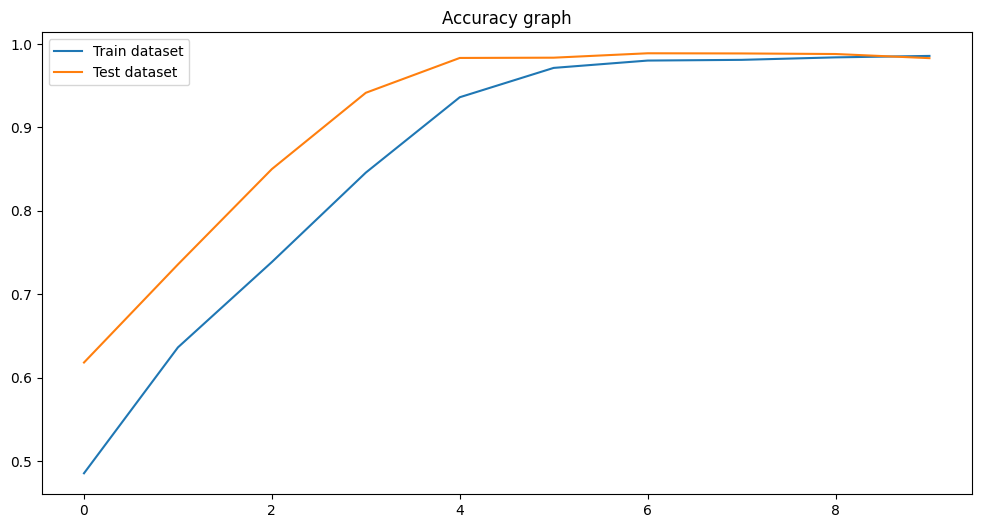

In [29]:
keys = list(history.history.keys())

plt.figure(figsize=(12,6)) # table with 12 x 6
plt.plot(history.history[keys[1]], label='Train dataset')

if len(keys) > 2:
    plt.plot(history.history['val_' + keys[1]], label='Test dataset')

plt.legend()
plt.title('Accuracy graph')
plt.show()

1/1 [==============================] - 0s 26ms/step

0.00 % for airplane
100.00 % for automobile
0.00 % for bird
0.00 % for cat
0.00 % for deer
0.00 % for dog
0.00 % for frog
0.00 % for horse
0.00 % for ship
0.00 % for truck

OUTPUT => automobile
CORRECT ANSWER => automobile


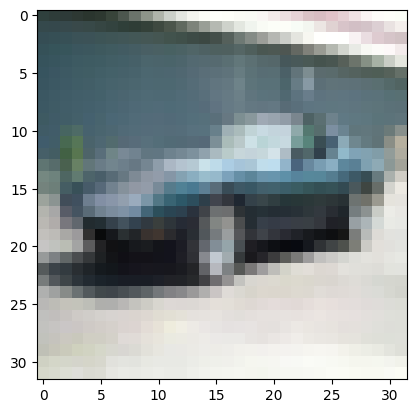

In [35]:
def test(test_index: int) -> None:
    
    img_arr = test_prepared_dataset[test_index]
    value = test_prepared_dataset_marks[test_index]

    correct_ans = np.argmax(value)
    img_expanded = np.expand_dims(img_arr, axis=0)

    plt.imshow(img_arr)
    
    result = model.predict(img_expanded)
    predicted_number = np.argmax(result[0])
    
    print()
    for i, perc in enumerate(result[0]):
        print(f'{perc * 100:.2f} % for {NUMBER_TO_LABEL_MAPPING[i]}')

    print()
    print(f'OUTPUT => {NUMBER_TO_LABEL_MAPPING[predicted_number]}')
    print(f'CORRECT ANSWER => {NUMBER_TO_LABEL_MAPPING[correct_ans]}')

test(6789)